Try the convergence study for e-region convergence, but with randomized configurations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))
from convergence_problem import ConvergenceProblem
import seaborn as sns
import pickle
import pandas as pd
from numpy import random

In [3]:
class ConvergenceProblemE(ConvergenceProblem): # Alter to only vary over outermost region.
  def convergence_study_over_m0s(self, nmk_max, m0s): # First m0 should be the one given in Problem instantiation
    full_a_matrix = self.a_matrix()
    output = {}
    b_vector_lst = []
    c_vector_lst = [] # If inner regions don't change in NMK, c_vectors are the same.
    for i in range(self.boundary_count):
      self.heaving = [1 if index == i else 0 for index in range(self.boundary_count)]
      b_vector_lst.append(self.b_vector())
      c_vector_lst.append(self.c_vector())
    
    for m0 in m0s:
      out_for_m0 = {}
      if m0 != self.m0:
          self.change_m0(m0)
          full_a_matrix = self.a_matrix_from_old(full_a_matrix)
          for i in range(self.boundary_count):
            self.heaving = [1 if index == i else 0 for index in range(self.boundary_count)]
            b_vector_lst[i] = self.b_vector_from_old(b_vector_lst[i])
      all_a_matrices = self.get_sub_matrices(full_a_matrix, nmk_max)
      omega = self.angular_freq(self.m0)

      for i in range(self.boundary_count):
        self.heaving = [1 if index == i else 0 for index in range(self.boundary_count)]
        full_b_vector = b_vector_lst[i]
        full_c_vector = c_vector_lst[i]
        all_b_vectors = self.get_sub_vectors(full_b_vector, nmk_max)
        particular_contribution = self.int_phi_p_i(i) # only region i is heaving
        am_lst = []
        dp_lst = []
        for nmk in range(1, nmk_max + 1):
          x = self.get_unknown_coeffs(all_a_matrices[nmk - 1], all_b_vectors[nmk - 1])
          raw_hydro = 2 * np.pi * (np.dot(full_c_vector, x[:-nmk]) + particular_contribution)
          # follow the capytaine convention
          am_lst.append(raw_hydro.real * self.rho) # added mass
          dp_lst.append(raw_hydro.imag * omega * self.rho) # damping
        out_for_m0["ams" + str(i)] = am_lst
        out_for_m0["dps" + str(i)] = dp_lst
        x = self.get_unknown_coeffs(full_a_matrix, full_b_vector)
        am, dp = self.hydro_coeffs(x, "capytaine")
        out_for_m0["am" + str(i)] = am
        out_for_m0["dp" + str(i)] = dp
      output[m0] = out_for_m0
    return output
  
  def get_sub_matrices(self, full_a_matrix, nmk_max):
    big_nmk = self.NMK[-1]
    all_a_matrices = []
    for i in range(1, nmk_max + 1):
      a_matrix = full_a_matrix[: (self.size - big_nmk + i), : (self.size - big_nmk + i)]
      all_a_matrices.append(a_matrix)
    return all_a_matrices

  def get_sub_vectors(self, full_vector, nmk_max):
    big_nmk = self.NMK[-1]
    all_b_vectors = []
    for i in range(1, nmk_max + 1):
      b_vector = full_vector[: (self.size - big_nmk + i)]
      all_b_vectors.append(b_vector)
    return all_b_vectors

In [8]:
hs = list(np.linspace(5, 50, 10))
uniform_m0s = list(np.linspace(0.5, 5, 10))
ds = [[1, 2, 3], [2, 3, 2], [3, 2, 1]]
a_s = [[1, 2, 3], [0.5, 1.5, 3.5], [2, 3, 3.5]]
big_nmk = 200
nmk_max = 150

NMK = [big_nmk] * 4
rho = 1023

file1 = "predetermined_configs.pkl"
file2 = "random_e_convergence.pkl"

In [4]:
def merge_dicts(dict1, dict2): # Creates a copy, favoring the values of dict2 for shared keys.
  dict3 = dict1.copy()
  for key in dict2.keys():
    dict3[key] = dict2[key]
  return dict3

def update_data_file(data, name):
  with open(name, "wb") as f:
    pickle.dump(data, f)

def random_d_a(h):
  # need radwidth/(h-d) < 1
  d = []
  a = []
  rad_widths = []
  for i in range(3):
    di = random.uniform(low = 0.0, high = (h - 1))
    rad_width_i = random.uniform(low = 0, high = (h - di))
    d.append(di)
    rad_widths.append(rad_width_i)
    a.append(sum(rad_widths))
  return d, a

def random_m0s(h):
  # need m0 * h < 75
  return list(random.uniform(low=0.0, high=(75/h), size = 5))


In [37]:
# data = []
# for h in hs:
#   for d in ds:
#     for a in a_s:
#       data_dict = {"h" : h,
#                    "d" : d,
#                    "a" : a}
#       prob = ConvergenceProblemE(h, d, a, [1, 1, 1, 1], NMK, m0s[0], rho)
#       results = prob.convergence_study_over_m0s(nmk_max, m0s)
#       data.append(merge_dicts(data_dict, results))
#       update_data_file(data, file1)
#       print("Finished run through an a.")
#     print("Finished run through a d.")
#   print("Finished run through an h.")


# data = []
# for h in hs:
#   for i in range(4): # 4 physical configurations per.
#     m0s = random_m0s(h)
#     d, a = random_d_a(h)
#     data_dict = {"h" : h,
#                   "d" : d,
#                   "a" : a,
#                   "m0s" : m0s}
#     prob = ConvergenceProblemE(h, d, a, [1, 1, 1], NMK, m0s[0], rho)
#     results = prob.convergence_study_over_m0s(nmk_max, m0s)
#     data.append(merge_dicts(data_dict, results))
#     update_data_file(data, "random_e_convergence.pkl")
#     print("Finished a config.")
#   print("Finished run through an h.")

# with open(file1, "rb") as f: # predetermined configurations
#   data = pickle.load(f)

with open(file2, "rb") as f: # randomly spaced configurations
  data = pickle.load(f)


In [38]:
def convergence_point(data_dict, hydro, region, error):
  hydros = data_dict[hydro + "s" + str(region)]
  true_value = data_dict[hydro + str(region)]
  incumbent = len(hydros)
  for nmk in range(len(hydros), 0, -1):
    if abs((hydros[nmk - 1] - true_value)/true_value) <= error:
      incumbent = nmk
    else: # after this point, consistently <= error away.
      break
  return incumbent

hydro_keys = ["am", "dp"]

errors = [0.01, 0.005]
for data_dict in data:
  for m0 in data_dict["m0s"]:
    for hydro in hydro_keys:
      for region in range(3):
        for error in errors:
          data_dict[m0][f"convergence point {error:.2g} " + hydro + str(region)] = convergence_point(data_dict[m0], hydro, region, error)

def scale_by(lst, val):
  return [entry/val for entry in lst]

log_data = []

for data_dict in data:
  output = data_dict.copy()
  for m0 in data_dict["m0s"]:
    m0_output = {}
    for hydro in hydro_keys:
      for region in range(3):
        if data_dict[m0]["convergence point 0.01 " + hydro + str(region)] < 150:
          true_y = data_dict[m0][hydro + str(region)]
          ys = [np.log(abs(entry - 1)) for entry in scale_by(data_dict[m0][hydro + "s" + str(region)], true_y)]
          slope, intercept, r_value, p_value, std_err = stats.linregress(list(range(1, 151)), ys)
          m0_output[hydro + str(region)] = {"ys" : ys,
                                            "slope" : slope,
                                            "intercept" : intercept,
                                            "r2_value" : r_value ** 2,
                                            "p_value" : p_value,
                                            "std_err" : std_err}
        else: m0_output[hydro + str(region)] = None # Did not converge
    output[m0] = m0_output
  log_data.append(output)

am 2


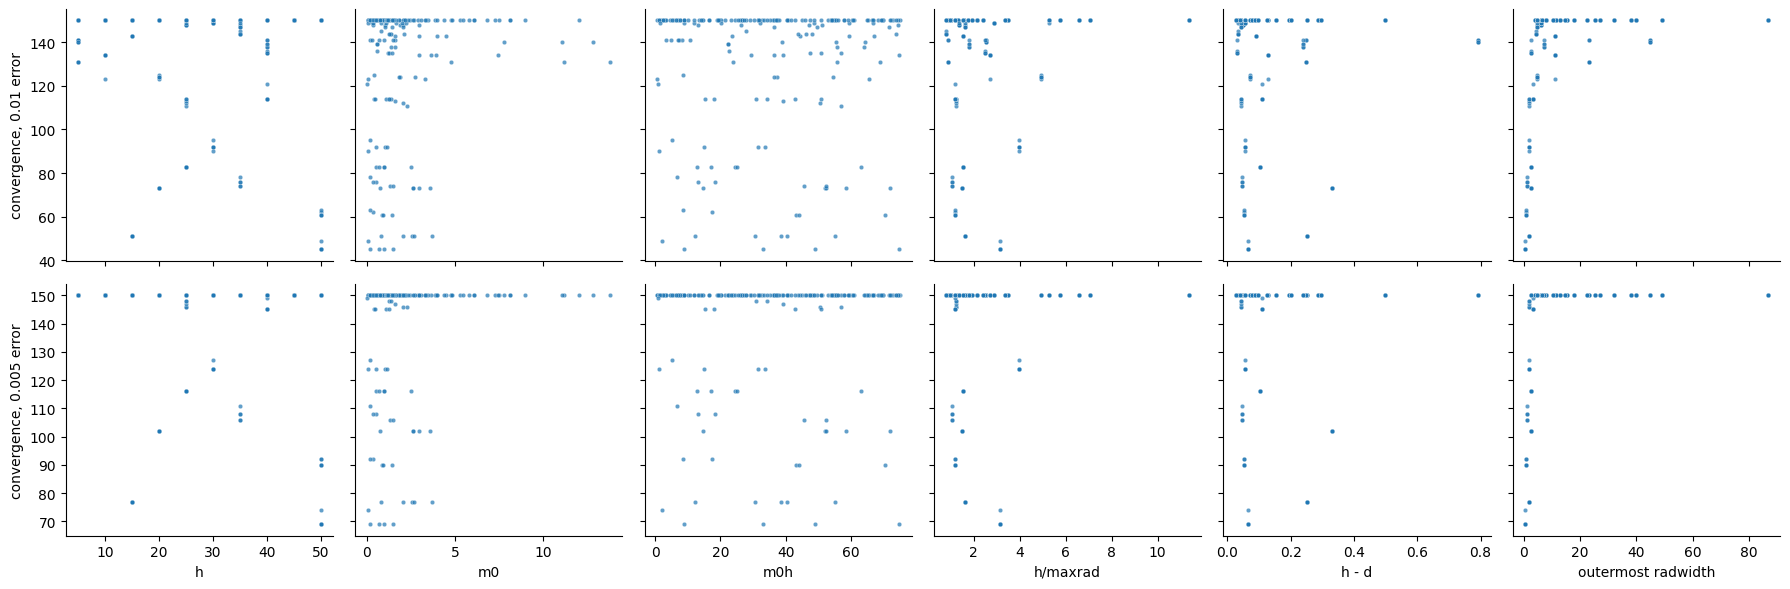

dp 2


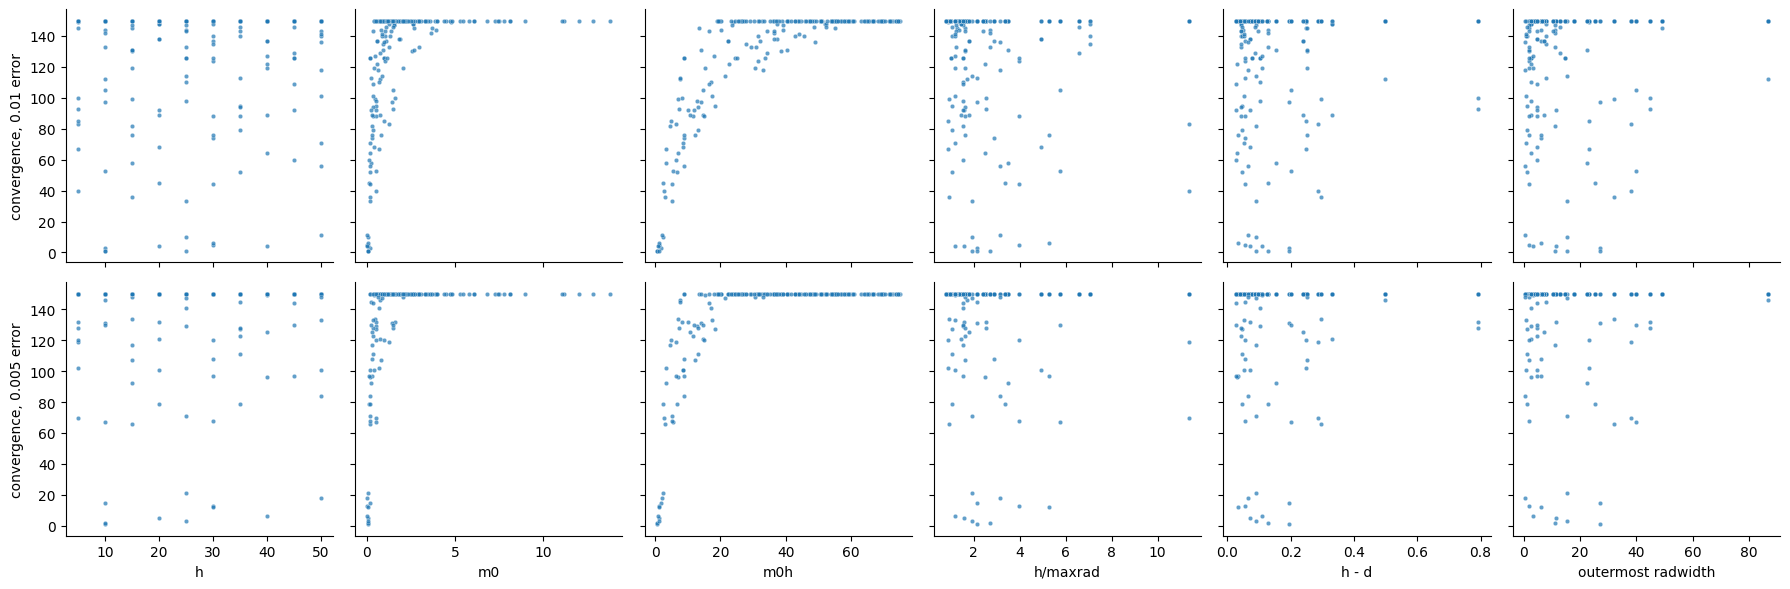

In [36]:
# Plot convergence point on y, m0, h, and m0h on x.
def xf1(config, m0):
  return config["h"]

def xf2(config, m0):
  return m0

def xf3(config, m0):
  return m0 * config["h"]

def xf4(config, m0):
  return config["h"]/(config["a"][-1])

def xf5(config, m0):
  return 1/ (config["h"] - config["d"][-1])

def xf6(config, m0):
  return 1/(config["a"][-1]- config["a"][-2])

def yf1(config, m0, hydro, region):
  return config[m0]["convergence point 0.01 " + hydro + str(region)]

def yf2(config, m0, hydro, region):
  return config[m0]["convergence point 0.005 " + hydro + str(region)]

x_funcs = {"h" : xf1,
           "m0" : xf2,
           "m0h" : xf3,
           "h/maxrad" : xf4,
           "h - d" : xf5,
           "outermost radwidth" : xf6}
y_funcs = {"convergence, 0.01 error" : yf1,
           "convergence, 0.005 error" : yf2}

def x_func_applier(f, data):
  output = []
  for data_dict in data:
    for m0 in data_dict["m0s"]:
      output.append(f(data_dict, m0))
  return output

def y_func_applier(f, data, hydro, region):
  output = []
  for data_dict in data:
    for m0 in data_dict["m0s"]:
      output.append(f(data_dict, m0, hydro, region))
  return output

def get_grid_values(data, hydro, region):
  transforms = {}
  for key in x_funcs.keys():
    transforms[key] = x_func_applier(x_funcs[key], data)
  for key in y_funcs.keys():
    transforms[key] = y_func_applier(y_funcs[key], data, hydro, region)
  return pd.DataFrame(transforms)

cols_x = x_funcs.keys()
cols_y = y_funcs.keys()

for key in hydro_keys:
  for region in [2]:
    transform_df = get_grid_values(data, key, region)
    g = sns.PairGrid(transform_df, x_vars=cols_x, y_vars=cols_y, height=3, aspect=1)
    g.map(sns.scatterplot, s=10, alpha=0.7)
    plt.tight_layout()
    print(key, region)
    plt.show()

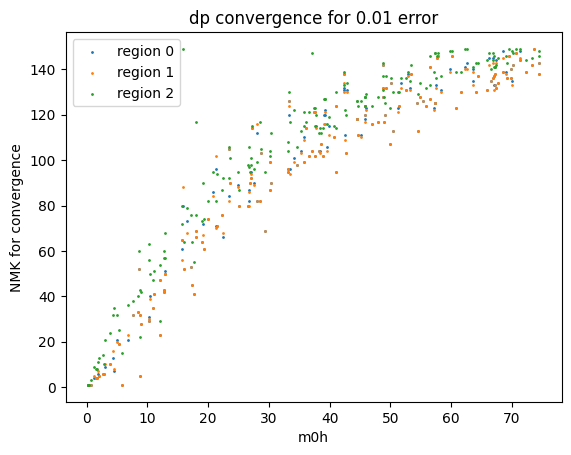

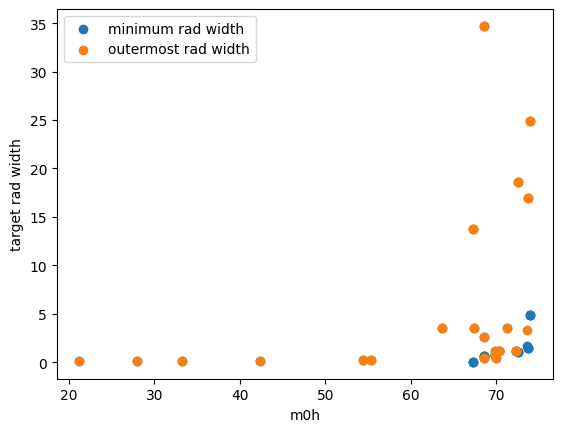

In [44]:
# There appears to be a pattern in damping, against m0h?
# Assuming AM always converges faster than DP, maybe try to extrapolate a relation from the damping data vs m0h.
# Plot each damping error against m0h, but cut out the unconverged.
def plot_hydro_vs_m0h(data, hydro, regions, error):
  secondary_xs = []
  secondary_ys = []
  tertiary_ys = []
  for region in regions:
    xs = []
    ys = []
    for data_dict in data:
      for m0 in data_dict["m0s"]:
        y = data_dict[m0][f"convergence point {error:.2g} " + hydro + str(region)]
        if y != 150:
          ys.append(y)
          xs.append(m0 * data_dict["h"])
        else:
          secondary_xs.append(m0 * data_dict["h"])
          secondary_ys.append(data_dict["a"][-1] - data_dict["a"][-2])
          tertiary_ys.append(min(data_dict["a"][-1] - data_dict["a"][-2], data_dict["a"][-2] - data_dict["a"][-3], data_dict["a"][0]))
    plt.scatter(xs, ys, label = f"region {region}", s = 1)
  
  plt.xlabel("m0h")
  plt.ylabel("NMK for convergence")
  plt.title(f"{hydro} convergence for {error:.2g} error")
  plt.legend()
  plt.show()

  plt.scatter(secondary_xs, tertiary_ys, label = "minimum rad width")
  plt.scatter(secondary_xs, secondary_ys, label = "outermost rad width")
  plt.xlabel("m0h")
  plt.ylabel("target rad width")
  plt.legend()
  plt.show()


# plot_hydro_vs_m0h(data, "am", [0, 1], 0.01)
# plot_hydro_vs_m0h(data, "am", [0, 1], 0.005)
plot_hydro_vs_m0h(data, "dp", [0, 1, 2], 0.01)
# plot_hydro_vs_m0h(data, "dp", [0, 1, 2], 0.005)


# xs = list(range(1, 151))
# for i in range(70, 90):
#   plt.plot(xs, log_data[i][0.5]["dp0"]["ys"])

# plt.show()

# for m0 in m0s:
#   plt.plot(xs, log_data[80][m0]["dp0"]["ys"])

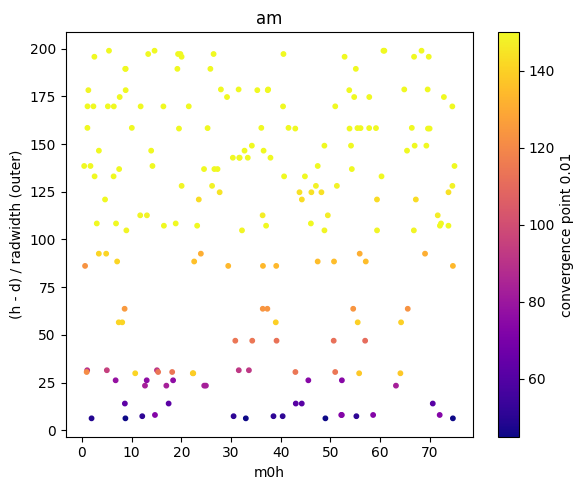

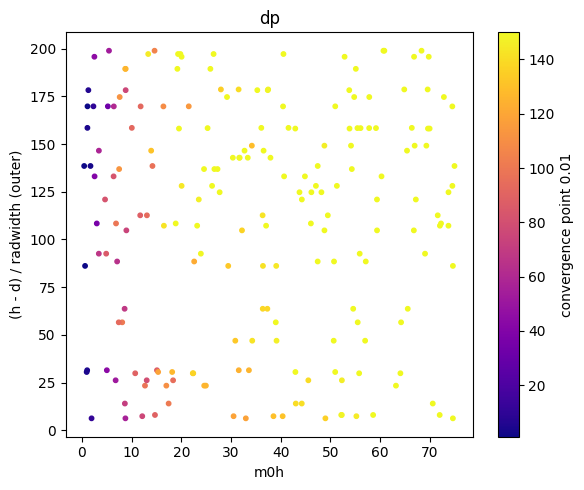

In [54]:
# Plot against both the outermost radial width and the m0h, with color displaying when it was converged.
def scatter_with_colormap(data, cmap='viridis', xlabel = "x", ylabel = "y", zlabel = "z", title = "title"):
    """
    Create a scatter plot where each point has:
      - x-coordinate = data[:, 0]
      - y-coordinate = data[:, 1]
      - color       = data[:, 2], mapped by a color map

    Parameters:
    - data: array-like of shape (n_points, 3)
    - cmap: name of a Matplotlib colormap
    """
    arr = np.asarray(data)
    if arr.ndim != 2 or arr.shape[1] != 3:
        raise ValueError("Data must be a 2D array with 3 columns per row.")

    x = arr[:, 0]
    y = arr[:, 1]
    c = arr[:, 2]

    plt.figure(figsize=(6, 5))
    sc = plt.scatter(x, y, c=c, cmap=cmap, s = 10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(sc)
    cbar.set_label(zlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_hydros_radwidth_m0h(data, hydro, region, error):
  xs = []
  ys = []
  zs = []
  for data_dict in data:
    for m0 in data_dict["m0s"]:
      z = data_dict[m0][f"convergence point {error:.2g} " + hydro + str(region)]
      # if z != 150:
      zs.append(z)
      xs.append(m0 * data_dict["h"])
      ys.append((data_dict["h"] - data_dict["d"][-1])/(data_dict["a"][-1] - data_dict["a"][-2])) # data_dict["a"][-1] - data_dict["a"][-2]
  data = np.column_stack((xs, ys, zs))
  scatter_with_colormap(data, cmap='plasma', xlabel = "m0h", ylabel = "(h - d) / radwidth (outer)",
                        zlabel = f"convergence point {error:.2g}", title = hydro)

plot_hydros_radwidth_m0h(data, "am", 2, 0.01)
plot_hydros_radwidth_m0h(data, "dp", 2, 0.01)

In [31]:
# Need more data. Run configs for various m0h, uniformly at random distributed (h - d)/radwidth from 1 to 200.
def random_h_minus_d_a(h):
  # need radwidth/(h-d) < 1
  h_minus_d_over_radwidth = random.uniform(low = 1., high = 200.)
  d = []
  a = []
  rad_widths = []
  for i in range(2): # Inner two regions
    di = random.uniform(low = 0.0, high = (h - 1))
    rad_width_i = random.uniform(low = 0, high = (h - di))
    d.append(di)
    rad_widths.append(rad_width_i)
    a.append(sum(rad_widths))
  # Outer region
  di = random.uniform(low = 0.0, high = (h - 1))
  rad_width_i = (h - di) / h_minus_d_over_radwidth
  d.append(di)
  rad_widths.append(rad_width_i)
  a.append(sum(rad_widths))
  return d, a

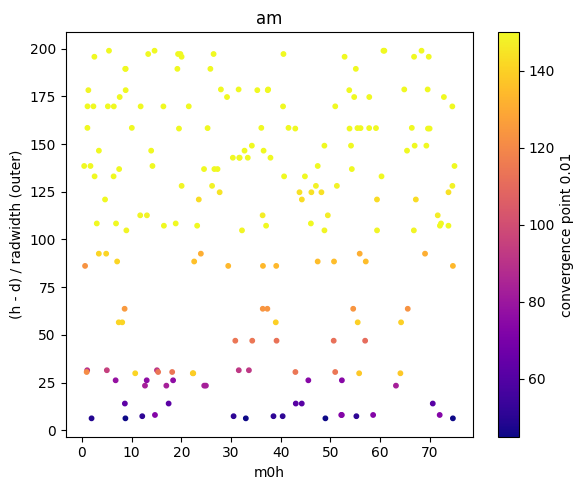

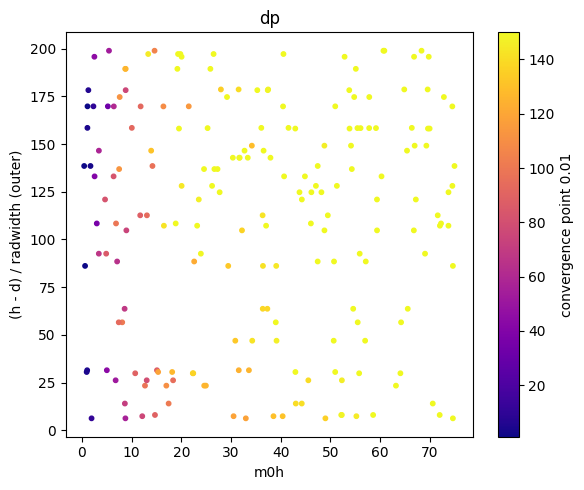

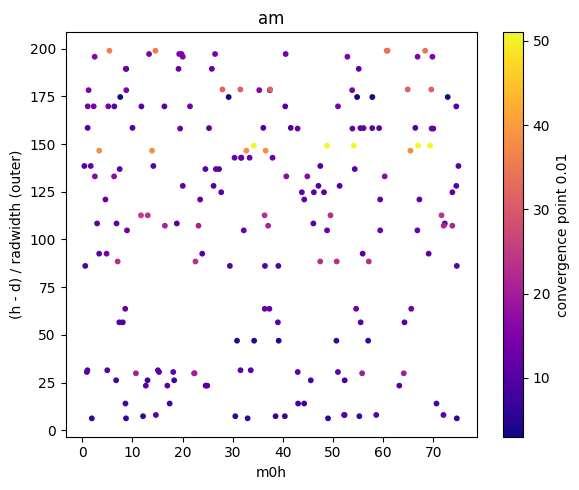

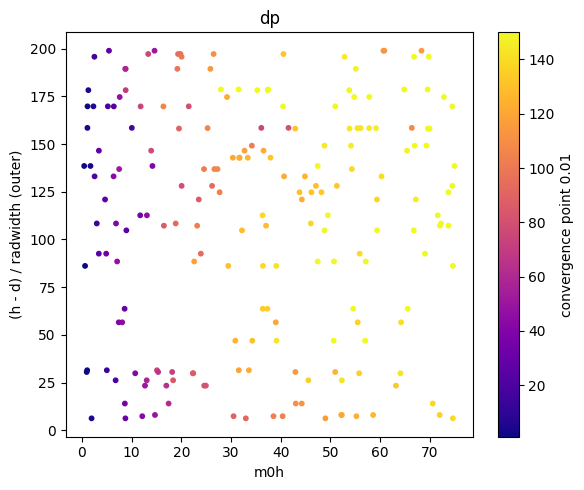

In [55]:
file3 = "ratioed_outer_region.pkl"

# data = []
# for h in hs:
#   for i in range(4): # 4 physical configurations per.
#     m0s = random_m0s(h)
#     d, a = random_h_minus_d_a(h)
#     data_dict = {"h" : h,
#                   "d" : d,
#                   "a" : a,
#                   "m0s" : m0s}
#     prob = ConvergenceProblemE(h, d, a, [1, 1, 1], NMK, m0s[0], rho)
#     results = prob.convergence_study_over_m0s(nmk_max, m0s)
#     data.append(merge_dicts(data_dict, results))
#     update_data_file(data, file3)
#     print("Finished a config.")
#   print("Finished run through an h.")

with open(file3, "rb") as f: # testing the region height/width hypothesis
  data = pickle.load(f)

for data_dict in data:
  for m0 in data_dict["m0s"]:
    for hydro in hydro_keys:
      for region in range(3):
        for error in errors:
          data_dict[m0][f"convergence point {error:.2g} " + hydro + str(region)] = convergence_point(data_dict[m0], hydro, region, error)

plot_hydros_radwidth_m0h(data, "am", 2, 0.01)
plot_hydros_radwidth_m0h(data, "dp", 2, 0.01)
plot_hydros_radwidth_m0h(data, "am", 1, 0.01)
plot_hydros_radwidth_m0h(data, "dp", 1, 0.01)

In [51]:
for data_dict in data:
  for m0 in data_dict["m0s"]:
      for region in range(3):
          pt = data_dict[m0][f"convergence point 0.01 am1"]
          if pt > 40:
             print(pt, data_dict["h"], data_dict["d"], data_dict["a"], m0)

51 45.0 [23.688406230650887, 37.76506913224595, 33.51647610312656] [5.7193073528218505, 6.75839509604609, np.float64(6.835394505860441)] 0.7598175581831783
51 45.0 [23.688406230650887, 37.76506913224595, 33.51647610312656] [5.7193073528218505, 6.75839509604609, np.float64(6.835394505860441)] 0.7598175581831783
51 45.0 [23.688406230650887, 37.76506913224595, 33.51647610312656] [5.7193073528218505, 6.75839509604609, np.float64(6.835394505860441)] 0.7598175581831783
51 45.0 [23.688406230650887, 37.76506913224595, 33.51647610312656] [5.7193073528218505, 6.75839509604609, np.float64(6.835394505860441)] 1.203189168184716
51 45.0 [23.688406230650887, 37.76506913224595, 33.51647610312656] [5.7193073528218505, 6.75839509604609, np.float64(6.835394505860441)] 1.203189168184716
51 45.0 [23.688406230650887, 37.76506913224595, 33.51647610312656] [5.7193073528218505, 6.75839509604609, np.float64(6.835394505860441)] 1.203189168184716
51 45.0 [23.688406230650887, 37.76506913224595, 33.51647610312656] 

In [ ]:
# Running through the same exact configurations as file3, do the convergence study wrt the outermost region instead of the outermost m0h